# Exploring the Data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

import pickle

from visualization.utils import correlation_histogram
from SP500models import industry
from data_pipeline.processing import *


In [2]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

In [3]:
closing_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2021-12-01 00:00:00-05:00 to 2023-11-01 00:00:00-04:00
Freq: MS
Columns: 497 entries, MMM to ZTS
dtypes: float64(497)
memory usage: 93.4 KB


We examine the data from two different industries

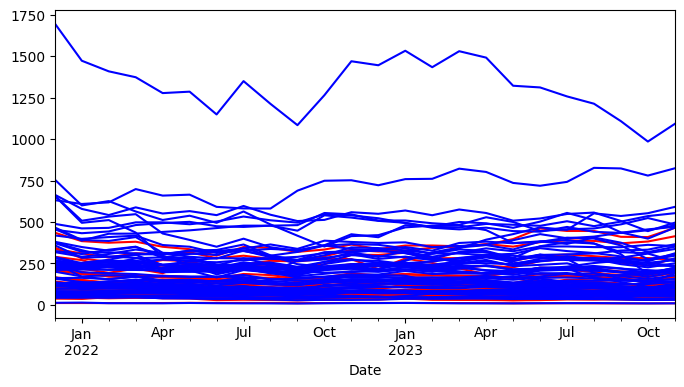

In [4]:
import matplotlib

MaterialsCols = [col for col in closing_prices.columns if industry_clusters[col] == 'Materials']
HealthCols = [col for col in closing_prices.columns if industry_clusters[col] == 'Health Care']

f, ax = plt.subplots(sharex = True, figsize = (8,4))

plot = closing_prices[MaterialsCols].plot(legend = False, ax = ax, color = 'red')
plot = closing_prices[HealthCols].plot(legend = False, ax = ax, color = 'blue')

As we can see, the price distribution of stocks is not uniform, so when clustering them like this, we will not get things that are informative to identify their motions. Thus, we choose a way to normalize:
- L^2 normalization: divides each column by its L^2 norm
- Percent normalization: instead of keeping track of the change in price, keep track of the *percent change in price*

We also had some other ideas to explore:
- Binary normalization: sign(percent normalization)
- Sharpe normalization: normalize by rate of return, and adjust for variance.

Let's explore what each of these normalizations does to the data

# Comparing Normalizations
$L^2$ normalization scales each stock price down so that they each have the same $L^2$ norm. This does not change the *shape* of the ticker, but moves all of the tickers down so that they can be compared in the same range of values.

One of the big problems with this normalization is that it does not carry much meaning in financial terms. While it may be mathematically elegant, there's not much we can do in terms of interpretation of what it means for a time series to have norm $1$. In fact, this normalization is "global" in the sense that past and future values of the time series affect the normalization of a single point in the time series. There are better normalizations we can use.

Rate of return normalization is defined by:
$$
ROR(t) = \frac{p(t+1) - p(t)}{p(t)} = \frac{p(t+1)}{p(t)} - 1
$$
and measures the rate at which a stock increases its value every day. This *does* have meaning in financial terms, and if both normalizations give reasonable looking time series, we prefer to use this one.

To better visualize what each normalization does to a collection of ticker prices, we restrict ourselves to a single industry sector - Materials.

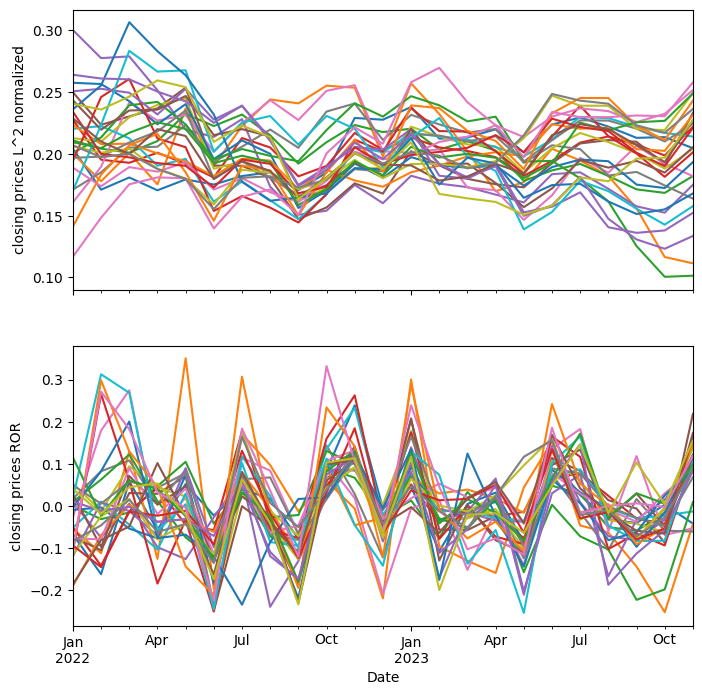

In [5]:
closing_prices_l2 = normalize(closing_prices)
ROR = closing_prices.pct_change().dropna()

f, axarr = plt.subplots(2,1, sharex = True, figsize = (8,8))

axarr[0].set_ylabel("closing prices L^2 normalized")
axarr[1].set_ylabel("closing prices ROR")

plot = closing_prices_l2[MaterialsCols].plot(legend = False, ax = axarr[0])
plot = ROR[MaterialsCols].plot(legend = False, ax = axarr[1])

One of these clearly looks better than the other -- $L^2$ normalizations look "cleaner" than the rate of return normalizations. We can fix this with a bit of data smoothing (more on this later)

It's hard to separate the different time series for clustering when visualized this way, so we collapse the plots onto the y axis as a histogram.

<Axes: xlabel='closing prices ROR', ylabel='Count'>

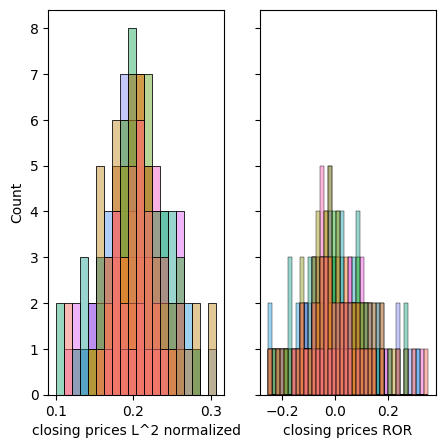

In [6]:
f, axarr = plt.subplots(1,2, sharey = True)
f.set_figheight(5)
f.set_figwidth(5)

axarr[0].set_xlabel("closing prices L^2 normalized")
axarr[1].set_xlabel("closing prices ROR")

sns.histplot(closing_prices_l2[MaterialsCols], legend = False, ax = axarr[0], bins = 20)
sns.histplot(ROR[MaterialsCols], legend = False, ax = axarr[1], bins = 40)

The above plots are coloured by ticker, and we are seeing all of the histograms of the values of the tickers overlayed on top of each other.

We notice a few things: 
 - pct looks a lot more like a normal distribution (in fact, in some models of stocks as random walks, $\log(1 + ROR)$ is predicted to be normally distributed, and for small returns, $\log(1 + ROR) \approx ROR = $)
 - L^2 normalized stocks have a mean which is not 0. This is due to the general market trend, where all stocks are roughly increasing in value. In the ROR plot, we can interpret the center of this histogram as the ''average daily rate of return for a portfolio consisting of all Materials stocks on the S&P500.'' This value is very close to $0$, but it doesn't have to be
 - This is just the data for one industry. We'd expect that plotting these histograms for two distinct industries may show a difference between their clusters
 
 We address these points one at a time.

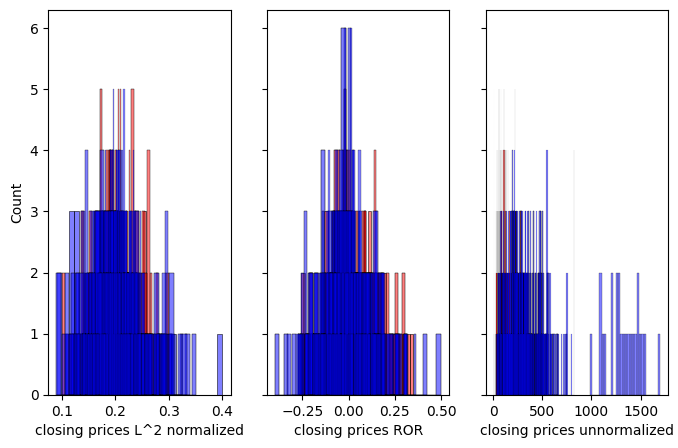

In [7]:
# Looking at the histograms of two distinct industies
f, axarr = plt.subplots(1,3, sharey = True)
f.set_figheight(5)
f.set_figwidth(8)

axarr[0].set_xlabel("closing prices L^2 normalized")
axarr[1].set_xlabel("closing prices ROR")
axarr[2].set_xlabel("closing prices unnormalized")

for tick in MaterialsCols:
    sns.histplot(closing_prices_l2[tick], legend = False, ax = axarr[0], bins = 30, color = 'red', alpha = 0.5)
    sns.histplot(ROR[tick], legend = False, ax = axarr[1], bins = 30, color = 'red', alpha = 0.5)
    sns.histplot(closing_prices[tick], legend = False, ax = axarr[2], bins = 30, color = 'red', alpha = 0.5)

for tick in HealthCols:
    sns.histplot(closing_prices_l2[tick], legend = False, ax = axarr[0], bins = 30, color = 'blue', alpha = 0.5)
    sns.histplot(ROR[tick], legend = False, ax = axarr[1], bins = 30, color = 'blue', alpha = 0.5)
    sns.histplot(closing_prices[tick], legend = False, ax = axarr[2], bins = 30, color = 'blue', alpha = 0.5)


Notice that we don't see any meaningful difference between healthcare and materials. A posteriori, this is to be expected, considering that theory tells us that ROR should be approximately normally distributed regardless of the equity. This plot should also make it very clear that not normalizing the data is a very bad idea, as the clustering would mostly just pick up on the price of the stock, which cannot be used to make money trading it.

Next, we examine how non-centered our ROR data is:

In [9]:
industry_averages = {}
industry_volatility = {}
for sector in industry_clusters.values():
    COLS = [col for col in closing_prices.columns if industry_clusters[col] == sector]
    industry_averages[sector] = ROR[COLS].mean().mean()
    industry_volatility[sector] = ROR[COLS].std(axis = 1).mean()


daily_ROR = pd.DataFrame.from_dict(industry_averages, orient='index', columns = ["Daily rate of return"])

daily_ROR["Mean daily volatility"] = industry_volatility.values()
daily_ROR

,Daily rate of return,Mean daily volatility
Industrials,0.004406,0.064572
Health Care,-0.004119,0.074332
Information Technology,0.003074,0.076226
Consumer Staples,-0.001597,0.055718
Utilities,0.000161,0.039824
Financials,0.001288,0.062709
Consumer Discretionary,-0.001598,0.083312
Materials,0.000495,0.071535
Real Estate,-0.007973,0.050691
Communication Services,-0.003951,0.081658


Before we move on to talking about clustering and correlations, we will try to visualize what each normalization does to the data.

Consider the health care sector. We plot the tickers, and colour them based on their L^2 norm, before and after normalization

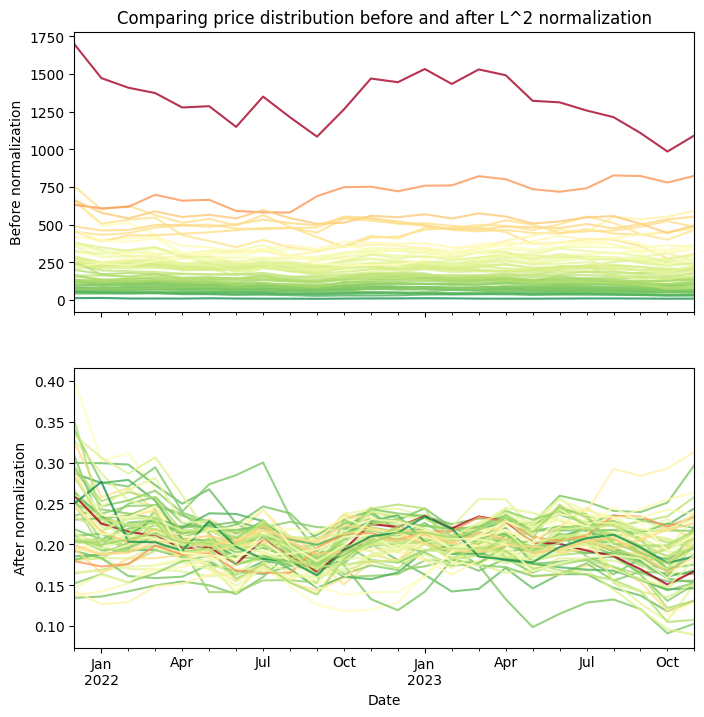

In [10]:
import matplotlib.cm as cm
HealthCols = [col for col in closing_prices.columns if industry_clusters[col] == 'Health Care']
norms = np.array([[np.linalg.norm(closing_prices[tick])] for tick in HealthCols])
cmap = cm.RdYlGn(1-np.sqrt(norms/max(norms)))
colors = [matplotlib.colors.rgb2hex(x) for x in cmap]

f, axarr = plt.subplots(2,1, sharex = True, figsize = (8,8))
axarr[0].set_title("Comparing price distribution before and after L^2 normalization")

axarr[0].set_ylabel("Before normalization")
axarr[1].set_ylabel("After normalization")

closing_prices[HealthCols].plot(legend = False, color = colors, ax = axarr[0], alpha = 0.8)
fig = closing_prices_l2[HealthCols].plot(legend = False, color = colors, ax = axarr[1], alpha = 0.8)

We do the same thing for percent normalization, adding some smoothing to better visualize what's going on.

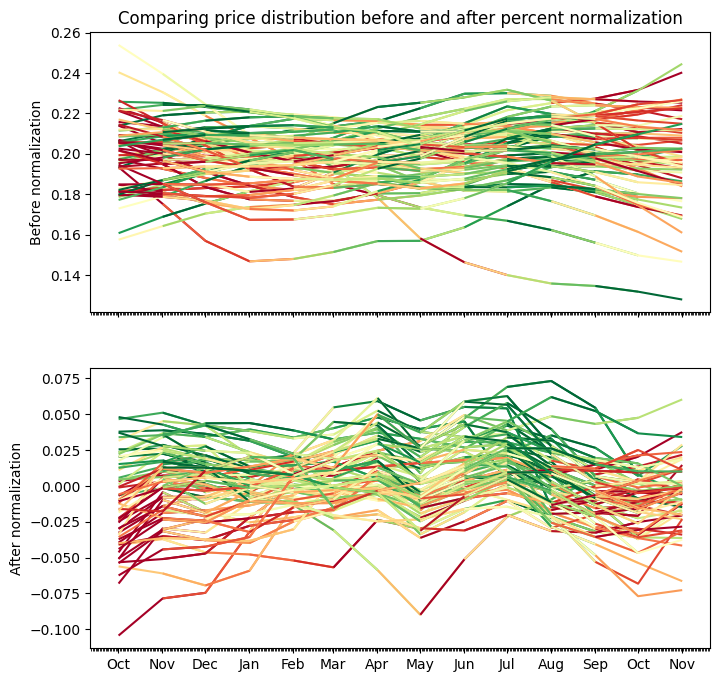

In [11]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

def colorplot(df, tick, ax, color = 'Percent'):
    tick_df = df[[tick]].rolling(10).mean().dropna().copy()
    if color == 'Percent':
        tick_df['color'] = tick_df.pct_change()
    else:
        tick_df['color'] = tick_df[tick]    
    
    tick_df = tick_df.dropna()

    xs = mdates.date2num(tick_df.index.to_pydatetime())
    pts = list(zip(xs, tick_df[tick]))
    segs = [[pts[i], pts[i+1]] for i in range(len(pts) - 1)]
    segments = np.hstack([segs[:-1], segs[1:]])
    
    colours = tick_df.color.values
    colours_normalized = (colours - min(colours))/(max(colours) - min(colours))
    cmap = cm.RdYlGn(colours_normalized)
    coll = LineCollection(segments, colors = cmap)
    
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    monthFmt = mdates.DateFormatter("%b")
    ax.xaxis.set_major_formatter(monthFmt)

f, axarr = plt.subplots(2,1, sharex = True, figsize = (8,8))
axarr[0].set_title("Comparing price distribution before and after percent normalization")

axarr[0].set_ylabel("Before normalization")
axarr[1].set_ylabel("After normalization")

#f, ax = plt.subplots()
for tick in HealthCols:
    colorplot(closing_prices_l2, tick, axarr[0])#, closing_prices_l2[[tick]].pct_change())
    colorplot(ROR, tick, axarr[1], color = 'value')


plt.show()

# Plotting the Shape of Returns
When we will cluster the data, each time series can be thought of as a vector in $\mathbb{R}^{250}$, with each entry corresponding to the returns or price of that day. One way to try to visualize this is to plot the data three days at a time in 3-dimensional slices.

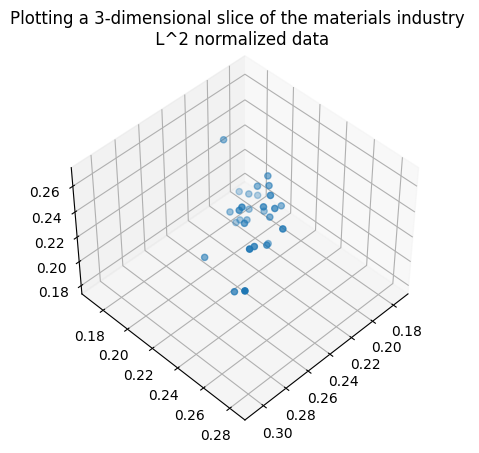

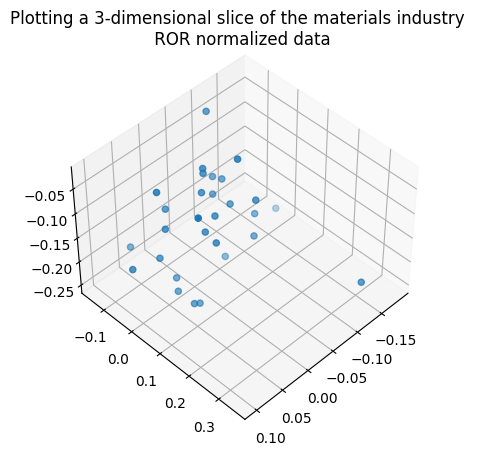

In [12]:
i = 3 # set the month here.

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Plotting a 3-dimensional slice of the materials industry \n L^2 normalized data")
ax.view_init(45,45)
df = closing_prices_l2[MaterialsCols]
ax.scatter(xs = df[i:i+1].values, ys = df[i+1:i+2].values, zs = df[i+2:i+3].values)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Plotting a 3-dimensional slice of the materials industry \n ROR normalized data")
ax.view_init(45,45)
df = ROR[MaterialsCols]
ax.scatter(xs = df[i:i+1].values, ys = df[i+1:i+2].values, zs = df[i+2:i+3].values)

Something very interesting to notice is that the ROR normalization seems to pull things apart spacially, meaning that it prepares the data better for clustering. This happens for most days.

Another thing to observe is that the data is generally quite blobby, meaning that either KMeans or DBSCAN would be good clustering algorithms to try out.

# Correlations as a Measure of Clustering
We are dealing with time series with around 250 entries, meaning that we are clustering on 250 dimensional data. As a preliminary exploration, we look at the correlation matrix of the closing price, and try to tease out when stocks are the same based on their correlation. We do this for L^2 and for pct change normalizations

In [13]:
def get_corrs(df, cols = None):
    if cols is None:
        cols = df.columns
    corrs = np.tril(df[cols].corr().values, -1) # do not return autocorrelations or duplicates
    corrs_locs = sorted(list(zip(*np.where(corrs > -1))), key = lambda a: corrs[a], reverse = True)
    return corrs_locs

In [14]:
import time
corrs_sorted = get_corrs(closing_prices_l2)

tickers = closing_prices_l2.columns
corr = closing_prices_l2.corr().values
for i, j in corrs_sorted[:15]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr[i][j]}")
    time.sleep(0.1) # My kernel crashed when things output too fast

Correlation between GOOG and GOOGL is: 0.9996716520452616
Correlation between FOX and FOXA is: 0.9965739825095831
Correlation between LEN and DHI is: 0.9950498976428983
Correlation between NWS and NWSA is: 0.9949127342526626
Correlation between MAA and CPT is: 0.9869850883161643
Correlation between TFC and KEY is: 0.9858018752006096
Correlation between ZION and CMA is: 0.9852676497493483
Correlation between SBAC and CCI is: 0.9831485172936685
Correlation between ESS and AVB is: 0.98300950671614
Correlation between NVDA and AVGO is: 0.9828568115499863
Correlation between SNPS and CDNS is: 0.9823990018216515
Correlation between PNC and KEY is: 0.982292953063121
Correlation between EQR and AVB is: 0.9814848872448535
Correlation between PNC and FITB is: 0.9800140178336713
Correlation between ESS and EQR is: 0.9797417525886888


We notice a few things:
- Some stocks are listed twice, such as NSW and NWSA. Usually this is because one class of shares have voting power and one does not. We should keep these pairs in mind for later, as they can be used for benchmarking our clustering algorithms.
- While not seen in the above printout, it is interesting to note that some usual suspects are highly correlated, like GOOG (Google) and AMZN (Amazon) (correlation about 0.95, a bit further up). But some of the most highly-correlated tickers are things like ZION and KEY, which are both small regional banks (in Utah and Idaho respectively), or LEN and DHI, both home construction companies

We examine low correlations as well.

In [15]:
for i, j in corrs_sorted[-15:]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr[i][j]}")
    time.sleep(0.1) # My kernel crashed when things output too fast
    

Correlation between BIIB and AIZ is: -0.9143111555936075
Correlation between HRL and CBOE is: -0.9170174721491445
Correlation between MCK and CPT is: -0.9171742586536632
Correlation between FICO and D is: -0.9171850768881299
Correlation between RVTY and MCK is: -0.9176569787342148
Correlation between WBA and MCK is: -0.9188698342302727
Correlation between CTLT and CAH is: -0.9192964391380002
Correlation between PCG and CTLT is: -0.9202294820317558
Correlation between VFC and VRTX is: -0.9272619455694304
Correlation between MCK and BIO is: -0.9277682800590391
Correlation between MAA and MCK is: -0.9278629713395541
Correlation between ORLY and D is: -0.9327337025669753
Correlation between TSN and CAH is: -0.9368351103556534
Correlation between TSN and ORLY is: -0.9375784866454494
Correlation between D and ACGL is: -0.9550511009671997


A quick plot shows what highly correlated and higly anti-correlated tickers look like:

<Axes: xlabel='Date', ylabel='highly anti-correlated'>

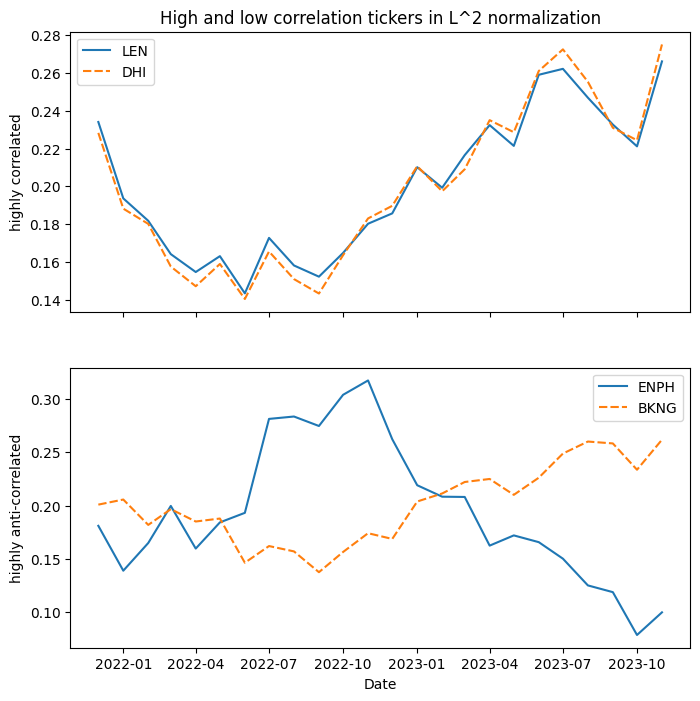

In [16]:
f, axarr = plt.subplots(2,1, sharex = True, figsize = (8,8))
axarr[0].set_title("High and low correlation tickers in L^2 normalization")

axarr[0].set_ylabel("highly correlated")
axarr[1].set_ylabel("highly anti-correlated")

sns.lineplot(data = closing_prices_l2[["LEN", "DHI"]], ax = axarr[0])
sns.lineplot(data = closing_prices_l2[["ENPH", "BKNG"]], ax = axarr[1])


We do the same thing for rate of return

In [17]:
corrs_sorted = get_corrs(ROR)

tickers = ROR.columns
corr = ROR.corr().values
print("High correlations:")
for i, j in corrs_sorted[:15]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr[i][j]}")
    time.sleep(0.1) # My kernel crashed when things output too fast
print("Low correlations:")
for i, j in corrs_sorted[-15:]:
    tick1 = tickers[i]
    tick2 = tickers[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr[i][j]}")
    time.sleep(0.1) # My kernel crashed when things output too fast

High correlations:
Correlation between GOOG and GOOGL is: 0.9987291882580631
Correlation between NWS and NWSA is: 0.9959825866510507
Correlation between FOX and FOXA is: 0.9900191641115892
Correlation between LEN and DHI is: 0.9715946067003854
Correlation between EQR and AVB is: 0.9674162521751295
Correlation between VMC and MLM is: 0.9648869407786417
Correlation between REG and FRT is: 0.9646355621713444
Correlation between SPGI and MCO is: 0.9543625332048522
Correlation between WEC and CNP is: 0.9543493515229546
Correlation between LYB and DOW is: 0.9524750241363485
Correlation between SLB and HAL is: 0.9522080619739842
Correlation between EOG and COP is: 0.9520790684171263
Correlation between HBAN and FITB is: 0.949437505979952
Correlation between STT and AMP is: 0.9443936850702175
Correlation between HES and EOG is: 0.9442677278433631
Low correlations:
Correlation between STX and GIS is: -0.4761425274840704
Correlation between TSLA and GIS is: -0.4761812122918708
Correlation betwee

Amazing! This seems to have found the duplicate stocks a better than the L^2 normalization, but the earlier high correlation between LEN and DHI is gone. They are still highly correlated, but are no longer close to the top of the list.

In [19]:
ROR[["LEN", "DHI"]].corr()

,LEN,DHI
LEN,1.000000,0.971595
DHI,0.971595,1.000000


<Axes: title={'center': 'Highly correlated returns \n EQR = real estate company \n AVB = some bank'}, xlabel='Date', ylabel='Returns'>

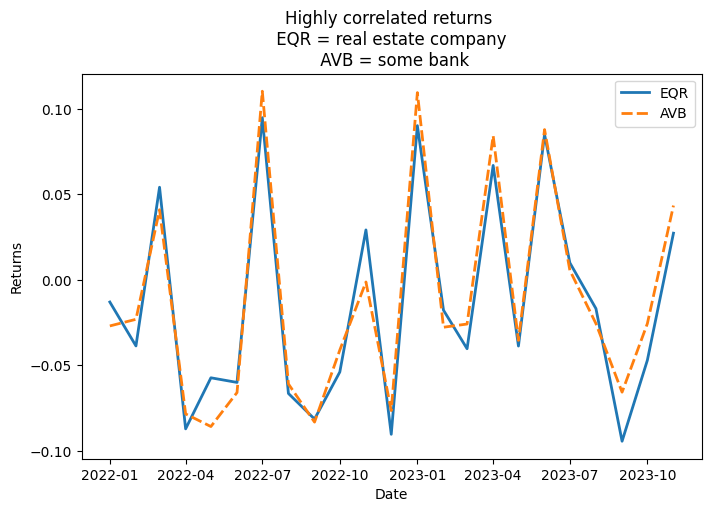

In [18]:
f, ax = plt.subplots(figsize = (8,5))
ax.set_title("Highly correlated returns \n EQR = real estate company \n AVB = some bank")

ax.set_ylabel("Returns")

sns.lineplot(data = ROR[["EQR", "AVB"]], ax = ax, linewidth = 2)


# Examining Correlation Histograms
It's impractical to look at all of the correlations in a 500x500 matrix. Nevertheless, we can still try to look at the *collection* of correlations to see if there are any equities that look like they *do* move together. We will plot some histograms of correlations

As a baseline model, we can cluster the equities by industry, and see if the correlations have anything to do with the industry of the equity.

We do this for L^2 and for sharpe normalizations.

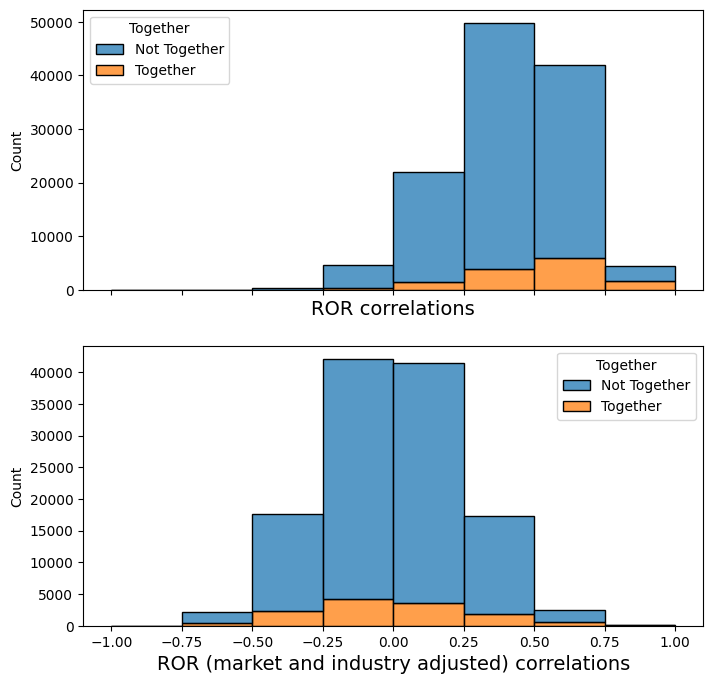

In [19]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")
ROR = closing_prices.pct_change().dropna()


f, axarr = plt.subplots(2,1, sharex = True)
f.set_figheight(8)
f.set_figwidth(8)

axarr[0].set_xlabel("ROR correlations", fontsize = 14)
axarr[1].set_xlabel("ROR (market and industry adjusted) correlations", fontsize = 14)

with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

ROR_adjusted = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))


correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])
correlation_histogram(ROR_adjusted, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[1])

#correlation_histogram(sharpe, bins = 20, clusters = industry_clusters, ax = axarr[2])

Interesting to note that the "industry" clusters perform well in the ROR normalization, but not so well in the L^2 normalization. Still, there's some things that seem quite correlated but are not in the same industry, and there are some things that are in the same industry but not correlated

# A bit on the industry clusters
We examine some of the industry clusters, making some plots of them, and looking at what they do to the data.

In [20]:
closing_prices_l2.columns = pd.MultiIndex.from_arrays((closing_prices_l2.columns.map(industry_clusters),
                                                    closing_prices_l2.columns),
                                                     names=['Industry', 'Ticker'])
ROR.columns = pd.MultiIndex.from_arrays((ROR.columns.map(industry_clusters),
                                                    ROR.columns),
                                                   names=['Industry', 'Ticker'])
industry_averages_l2 = closing_prices_l2.groupby(level=0, axis=1).mean()
industry_averages_ROR = ROR.groupby(level=0, axis=1).mean()

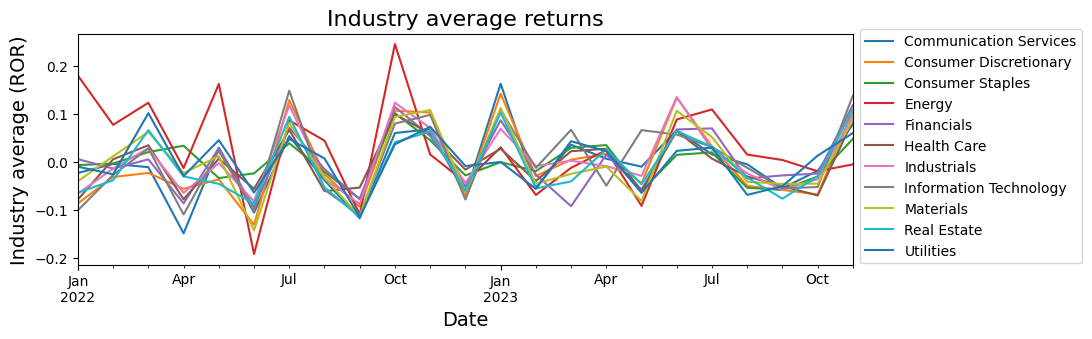

In [21]:
f, ax = plt.subplots(figsize = (10,3))
ax.set_ylabel("Industry average (ROR)", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)
ax.set_title("Industry average returns", fontsize = 16)

industry_averages_ROR.plot(ax = ax)
ax.legend(bbox_to_anchor=(1, 1.05))

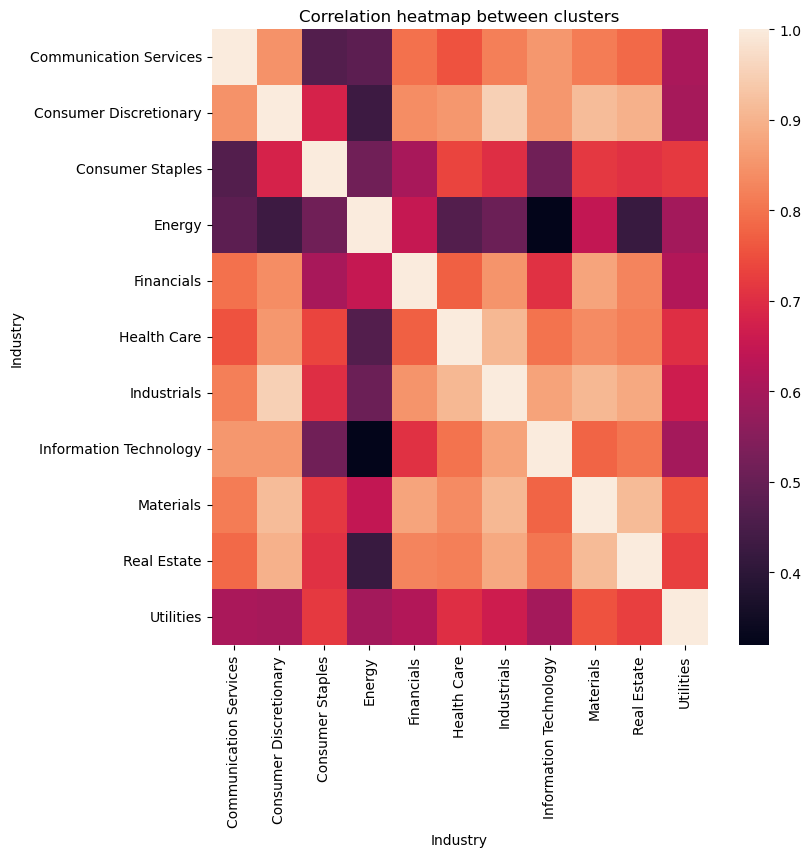

In [24]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

f = sns.heatmap(industry_averages_ROR.corr(), ax = ax)
t = ax.set_title("Correlation heatmap between clusters")

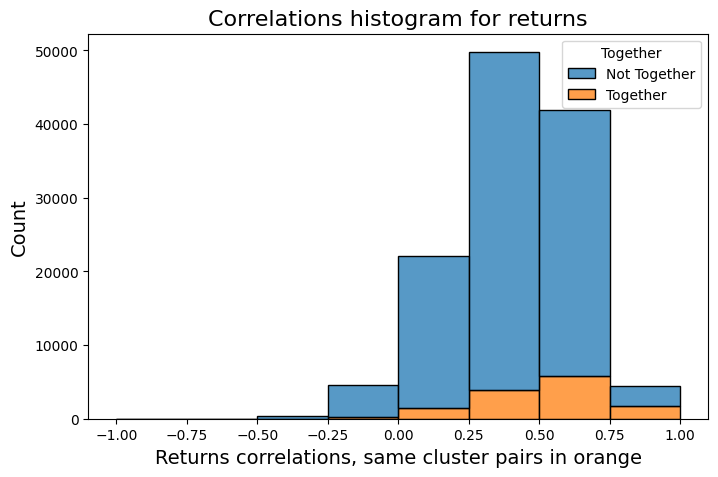

In [22]:
f, ax = plt.subplots(figsize = (8,5))

ax.set_title("Correlations histogram for returns", fontsize = 16)
ax.set_xlabel("Returns correlations, same cluster pairs in orange", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = ax)


# Making plots of the industry clusters

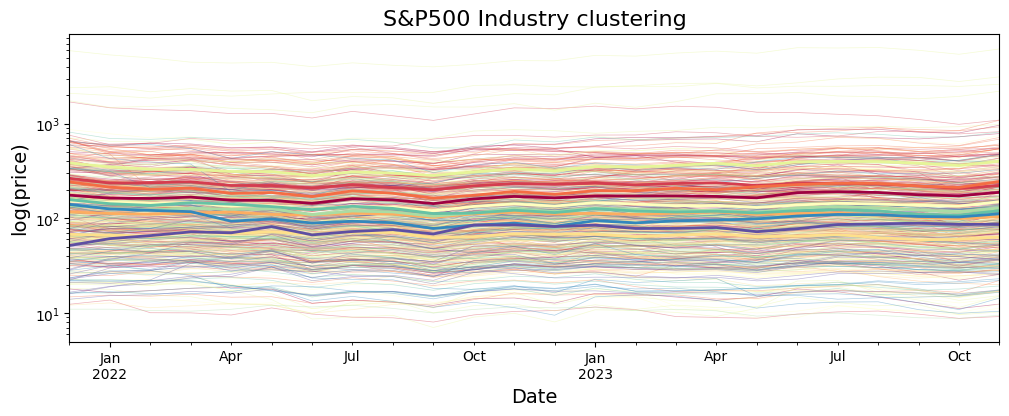

In [23]:
clust_to_tick = {label : [tick for tick in industry_clusters.keys() if industry_clusters[tick] == label] for label in industry_clusters.values()}

import matplotlib.cm as cm
fig, ax = plt.subplots(figsize = (12,4))
ax.set_yscale('log')
ax.set_ylabel('log(price)', fontsize = 14)
ax.set_title('S&P500 Industry clustering', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)

for i, label in enumerate(clust_to_tick.keys()):
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    closing_prices[clust_to_tick[label]].plot(legend = False, color = color, ax=ax, alpha = 0.4, linewidth = 0.5)
for i, label in enumerate(clust_to_tick.keys()):
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    closing_prices[clust_to_tick[label]].mean(axis = 1).plot(legend = False, color = color, ax=ax, alpha = 1, linewidth = 2)


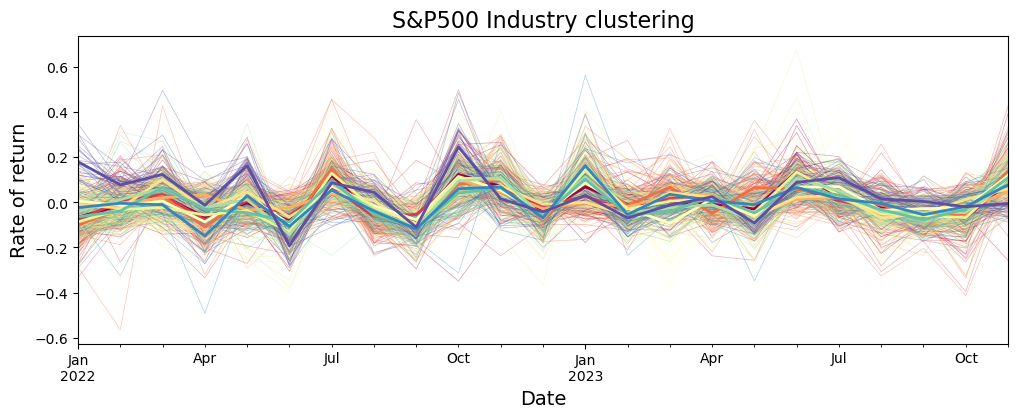

In [27]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylabel('Rate of return', fontsize = 14)
ax.set_title('S&P500 Industry clustering', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)

ROR = closing_prices.pct_change().dropna()

for i, label in enumerate(clust_to_tick.keys()):
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    ROR[clust_to_tick[label]].plot(legend = False, color = color, ax=ax, alpha = 0.4, linewidth = 0.5)
for i, label in enumerate(clust_to_tick.keys()):
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    ROR[clust_to_tick[label]].mean(axis = 1).plot(legend = False, color = color, ax=ax, alpha = 1, linewidth = 2)


# Sharpe Normalization
A third possible normalization, which we will not explore, is to normalize by the Sharpe ratio.

In [24]:
sigma = risk(ROR, window = 10) # this is the risk
sharpe = sharpe_normalize(closing_prices, window = None) # uses constant risk estimate

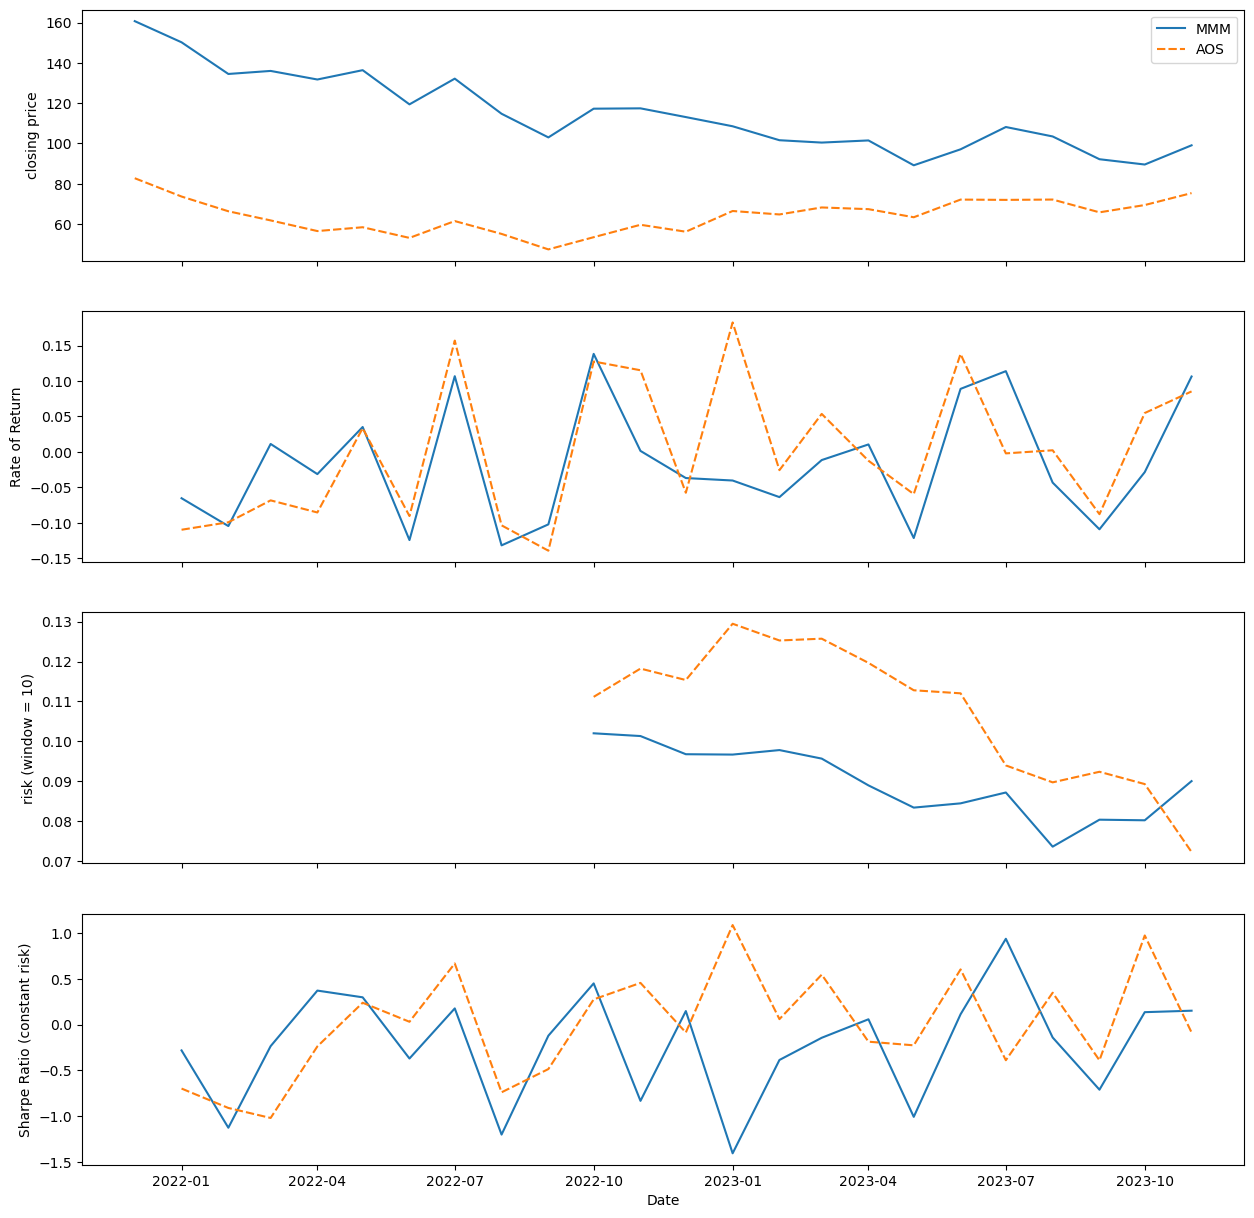

In [29]:
f, axarr = plt.subplots(4, sharex=True)
f.set_figheight(15)
f.set_figwidth(15)

k  = 2
sns.lineplot(data = closing_prices[closing_prices.columns[0:k]], ax = axarr[0])
y = axarr[0].set_ylabel("closing price")
sns.lineplot(data = ROR[ROR.columns[0:k]], ax = axarr[1], legend = False)
y = axarr[1].set_ylabel("Rate of Return")
sns.lineplot(data = sigma[sigma.columns[0:k]], ax = axarr[2], legend = False)
y = axarr[2].set_ylabel("risk (window = 10)")
sns.lineplot(data = sharpe[sharpe.columns[0:k]], ax = axarr[3], legend = False)
y = axarr[3].set_ylabel("Sharpe Ratio (constant risk)")

# Subindustry Clustering
There is a further refinement of the industry clusters given by subindustry. We talk a bit about it here, doing the same correlation histogram analysis that we did before.

In [25]:
tickers = closing_prices.columns

industries = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
industries = industries[0][["Symbol", "GICS Sub-Industry"]].set_index("Symbol")["GICS Sub-Industry"].to_dict()
subindustry_clusters = {tick : industries[tick] for tick in tickers}

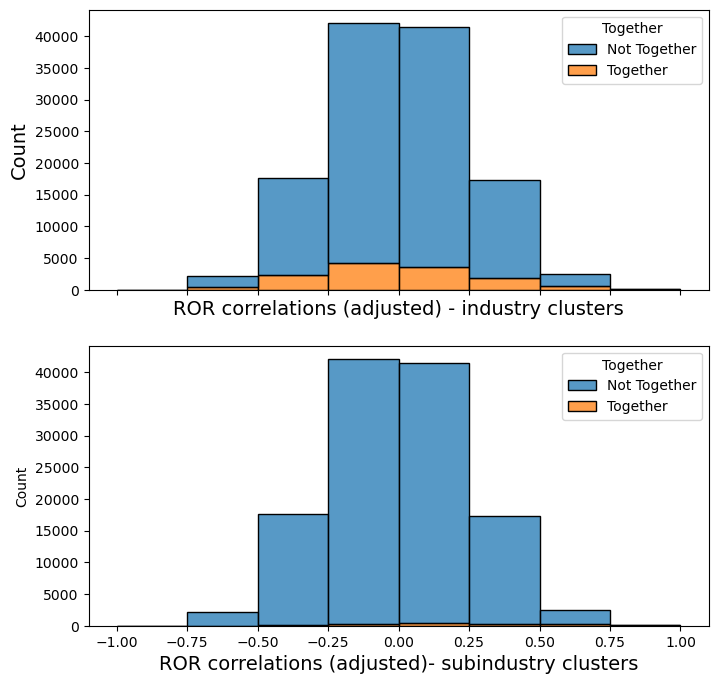

In [31]:
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)
    
ROR = closing_prices.pct_change().dropna()

f, axarr = plt.subplots(2,1, sharex = True)
f.set_figheight(8)
f.set_figwidth(8)

axarr[0].set_xlabel("ROR correlations (adjusted) - industry clusters", fontsize=14)
axarr[0].set_ylabel("Count", fontsize=14)
axarr[1].set_xlabel("ROR correlations (adjusted)- subindustry clusters", fontsize=14)
#axarr[2].set_xlabel("Sharpe correlations")

correlation_histogram(ROR_adjusted, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])
correlation_histogram(ROR_adjusted, bins = np.linspace(-1,1,9), clusters = subindustry_clusters, ax = axarr[1])


As we can see, the subindustry clusters are far to granular to capture the similarity between different stocks.